In [1]:
from lsmulator import *
from workloads import *
import numpy as np
import matplotlib.pyplot as plt
from figure_grid import *
from bloom_assignments import *

def compare_cache_improvements(wl, cs=100, dM=1, **kwargs):
  queries = wl.queries
  t1 = LSMulator.emulate(queries, cache_size=cs, **kwargs)
  t2 = LSMulator.emulate(queries, cache_size=cs+dM, **kwargs)
  return t1.disk_accesses - t2.disk_accesses, t1.bigger_cache_savings(dM=dM)

def compare_memtbl_improvements(wl, ms=100, dM=1, **kwargs):
  queries = wl.queries
  t1 = LSMulator.emulate(queries, memtbl_size=ms, **kwargs)
  t2 = LSMulator.emulate(queries, memtbl_size=ms+dM, **kwargs) 
  return t1.disk_accesses - t2.disk_accesses, t1.bigger_memtbl_savings(dM=dM)

def compare_bloom_improvements(wl, bs=100, dM=1, ballocs=monkey_assignment, **kwargs):
  queries = wl.queries
  t = LSMulator.emulate(queries, **kwargs)
  b1 = ballocs(bs, t.memtbl.size, t.layer_sizes)
  b2 = ballocs(bs+dM, t.memtbl.size, t.layer_sizes)
  t1 = LSMulator.emulate(queries, bloom_size=b1, **kwargs)
  t2 = LSMulator.emulate(queries, bloom_size=b2, **kwargs)
  return t1.disk_accesses - t2.disk_accesses, t1.bigger_bloom_savings(dM=dM, ballocs=ballocs)

def plot_savings(savings, wl, component):
  lim = max(abs(savings.min()), abs(savings.max()))
  plt.xlim(-lim, lim)
  plt.hist(savings[:,0], bins=8, alpha=0.5, label='Simulated')
  plt.hist(savings[:,1], bins=8, alpha=0.5, label='Predicted')
  plt.axvline(savings[:,1].mean(), label='Pred. Avg.', lw=3, color='green')
  plt.axvline(savings[:,0].mean(), ls='--', label='Sim. Avg.', lw=3, color='blue')

  plt.legend(loc='best', fontsize=8)
  plt.xlabel('I/Os Saved with Bigger ' + component)
  plt.ylabel('Frequency')
  plt.title(component + ' Savings Estimation for\n' + wl.title())

In [2]:
import pickle
c1,c2,c3 = pickle.load(open('./cache_savings.pkl', 'rb'))
b1,b2,b3 = pickle.load(open('./bloom_savings.pkl', 'rb'))
m1,m2,m3 = pickle.load(open('./memtbl_savings.pkl', 'rb'))

In [ ]:
c1 = np.array([compare_cache_improvements(ZipfWorkload()) for _ in range(250)])

In [5]:
c2 = np.array([compare_cache_improvements(UniformWorkload()) for _ in range(250)])

In [6]:
c3 = np.array([compare_cache_improvements(DiscoverDecayWorkload()) for _ in range(250)])

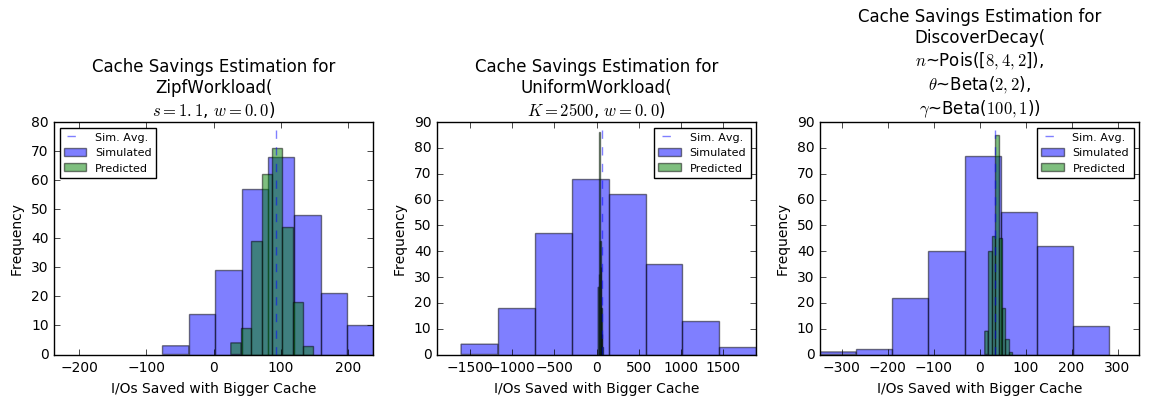

In [86]:
plt.figure(figsize=(14,3))
plt.subplot(131)
plot_savings(c1, ZipfWorkload(), 'Cache')
plt.subplot(132)
plot_savings(c2, UniformWorkload(), 'Cache')
plt.subplot(133)
plot_savings(c3, DiscoverDecayWorkload(), 'Cache')
plt.show()

In [29]:
m1 = np.array([compare_memtbl_improvements(ZipfWorkload()) for _ in range(250)])
m2 = np.array([compare_memtbl_improvements(UniformWorkload()) for _ in range(250)])
m3 = np.array([compare_memtbl_improvements(DiscoverDecayWorkload()) for _ in range(250)])

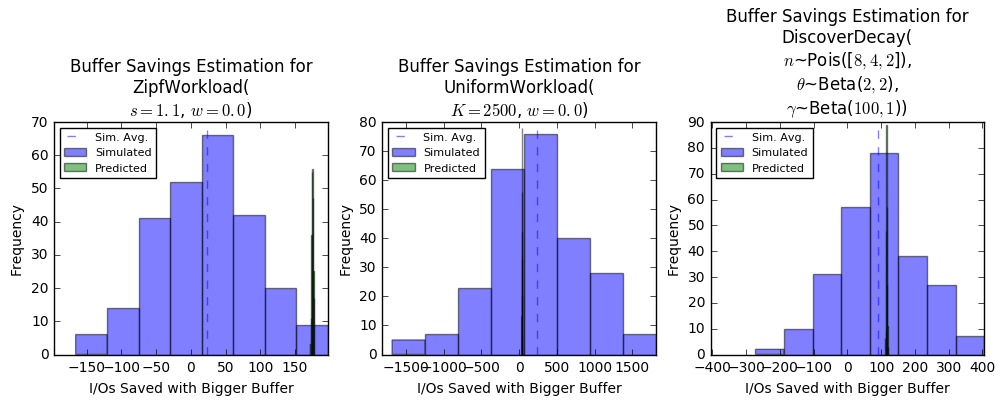

In [88]:
plt.figure(figsize=(12,3))
plt.subplot(131)
plot_savings(m1, ZipfWorkload(), 'Buffer')
plt.subplot(132)
plot_savings(m2, UniformWorkload(), 'Buffer')
plt.subplot(133)
plot_savings(m3, DiscoverDecayWorkload(), 'Buffer')
plt.show()

In [31]:
b1 = np.array([compare_bloom_improvements(ZipfWorkload()) for _ in range(250)])
b2 = np.array([compare_bloom_improvements(UniformWorkload()) for _ in range(250)])
b3 = np.array([compare_bloom_improvements(DiscoverDecayWorkload()) for _ in range(250)])

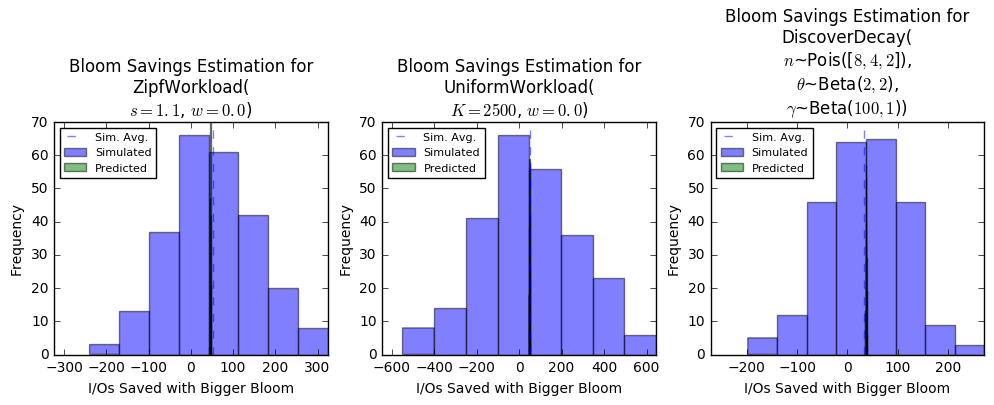

In [87]:
plt.figure(figsize=(12,3))
plt.subplot(131)
plot_savings(b1, ZipfWorkload(), 'Bloom')
plt.subplot(132)
plot_savings(b2, UniformWorkload(), 'Bloom')
plt.subplot(133)
plot_savings(b3, DiscoverDecayWorkload(), 'Bloom')
plt.show()

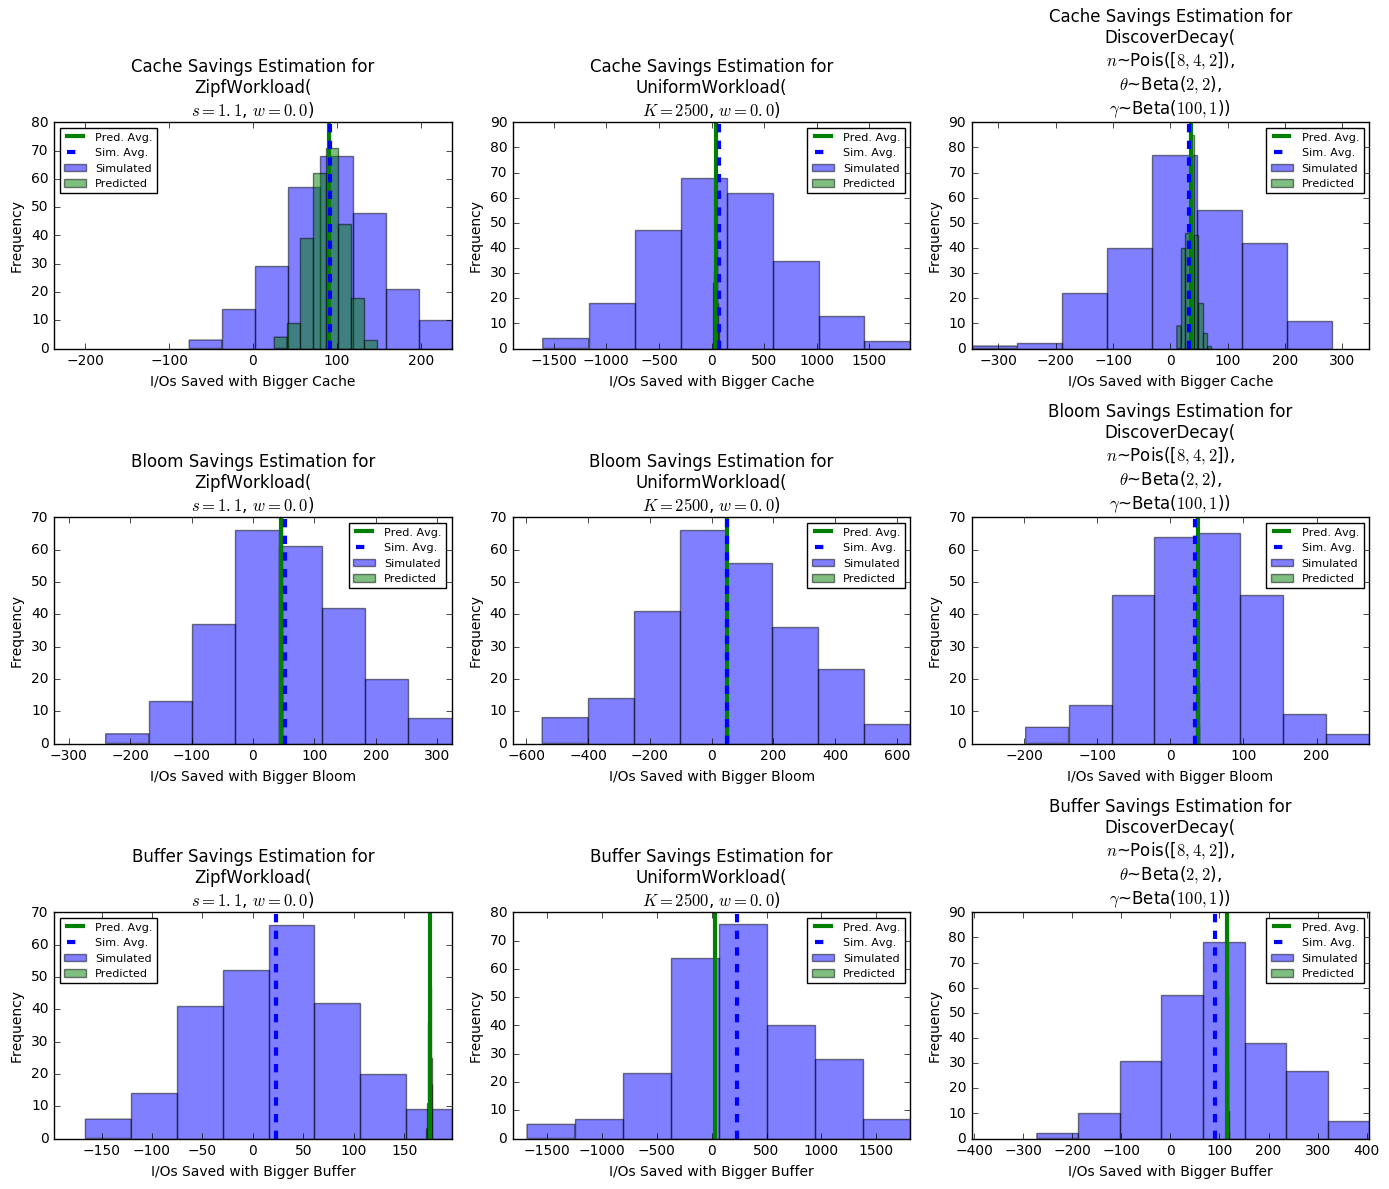

In [107]:
with figure_grid(3,3, rowwidth=14, rowheight=4) as g:
  g.next(); plot_savings(c1, ZipfWorkload(), 'Cache')
  g.next(); plot_savings(c2, UniformWorkload(), 'Cache')
  g.next(); plot_savings(c3, DiscoverDecayWorkload(), 'Cache')
  
  g.next(); plot_savings(b1, ZipfWorkload(), 'Bloom')
  g.next(); plot_savings(b2, UniformWorkload(), 'Bloom')
  g.next(); plot_savings(b3, DiscoverDecayWorkload(), 'Bloom')
  
  g.next(); plot_savings(m1, ZipfWorkload(), 'Buffer')
  g.next(); plot_savings(m2, UniformWorkload(), 'Buffer')
  g.next(); plot_savings(m3, DiscoverDecayWorkload(), 'Buffer')

In [181]:
print([len(l.mergereads) for l in zt1.layers])
print([len(l.mergewrites) for l in zt1.layers])
print([len(l.entries) for l in zt1.layers])
print('')
print([len(l.mergereads) for l in zt2.layers])
print([len(l.mergewrites) for l in zt2.layers])
print([len(l.entries) for l in zt2.layers])

[122, 60, 29, 13, 5, 1]
[123, 61, 30, 14, 6, 2]
[100, 200, 800, 1600, 3200, 6400]

[121, 59, 28, 13, 5, 1]
[122, 60, 29, 14, 6, 2]
[202, 404, 404, 1616, 3232, 6464]


In [127]:
def estimate_memsavings(t, dM=1):
  mt = t.memtbl
  extra_hits = (mt.hits * (mt.size+dM)/(mt.size)) - mt.hits
  
  return extra_hits * (t.disk_accesses / t.layer_queries)

In [3]:
wl = ZipfWorkload()
zt1 = LSMulator.emulate(wl.queries, memtbl_size=100)
zt2 = LSMulator.emulate(wl.queries, memtbl_size=101)
print(m1[:,0].mean())

23.068


In [4]:
wl = UniformWorkload()
ut1 = LSMulator.emulate(wl.queries, memtbl_size=100)
ut2 = LSMulator.emulate(wl.queries, memtbl_size=101) 
print(m2[:,0].mean())

235.008


In [5]:
wl = DiscoverDecayWorkload()
dt1 = LSMulator.emulate(wl.queries, memtbl_size=100)
dt2 = LSMulator.emulate(wl.queries, memtbl_size=101) 
print(m3[:,0].mean())

91.856


In [6]:
def ceil(n): return int(np.ceil(n))

In [7]:
ceil(zt1.layers[0].n_out / 256) + ceil(0.5*zt1.layers[0].n_out / 256)

71

In [8]:
zt1.layers[0].disk_accesses() - zt1.layers[0].accesses

241

In [14]:
[(l.read_accesses(), l.write_accesses(), l.dupes_squashed) for l in zt1.layers]

[(120, 121, 0),
 (88, 90, 0),
 (84, 86, 0),
 (70, 77, 0),
 (47, 60, 0),
 (13, 38, 0)]

In [15]:
[(l.read_accesses(), l.write_accesses(), l.dupes_squashed) for l in zt2.layers]

[(119, 120, 0),
 (87, 88, 0),
 (84, 86, 0),
 (70, 77, 0),
 (47, 60, 0),
 (13, 39, 0)]

In [16]:
[l.size/256 for l in zt1.layers]

[0.78125, 1.5625, 3.125, 6.25, 12.5, 25.0]

In [17]:
[(l.read_accesses(), l.write_accesses(), l.dupes_squashed) for l in dt2.layers]

[(105, 106, 477),
 (76, 78, 342),
 (60, 62, 420),
 (47, 53, 582),
 (30, 36, 394),
 (9, 26, 392)]

In [44]:
i = 0
print(sum(zt1.layers[i].mergereads))
print(sum(zt1.layers[i].mergewrites))
print((zt1.layers[i].n_in - len(zt1.layers[i].entries))*1.5)

18000
18100
18000.0


In [46]:
zt2.layers[0].n_in

12120

In [58]:
print(zt1.memtbl.n_in, zt2.memtbl.n_in)
print((zt1.memtbl.n_in // zt1.memtbl.size), (zt2.memtbl.n_in // zt2.memtbl.size))

print((zt1.memtbl.n_in // zt1.memtbl.size)*zt1.memtbl.size, (zt2.memtbl.n_in // zt2.memtbl.size)*zt2.memtbl.size)
print(zt1.layers[0].n_in, zt2.layers[0].n_in)

##hopefully number of writes to L1

print(ceil(zt1.layers[0].n_in/256) + ceil(zt1.layers[0].n_in*.5/256))
print(sum(zt1.layers[1].mergewrites))

12153 12153
121 120
12100 12120
12100 12120
72
60


In [62]:
zt1.layers[1].write_accesses()

90